## Binary Classification Model - With Transfer Learning

Now that we seen how augmentation can be added to improve the model, its time to use already built in networks that have been trained with bigger datasets in order to try extracting certain pattersn that could be useful for the problem at hand.

> Drive with files: https://drive.google.com/drive/folders/1l_thkTxtzfkN6Nifjilnvb3909TIX8QH?usp=share_link

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/AN2DL_HW1

Mounted at /gdrive
/gdrive/My Drive/AN2DL_HW1


In [ ]:
# Simple run of the imports and the filtered dataset

# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

images = np.load('clean_images.npy', allow_pickle=True)  #shape (5004,96,96,3)
labels = np.load('clean_labels.npy', allow_pickle=True)  #shape (5004,)

2.15.0


## Data preparation

Already covered on previous notebooks

In [ ]:
X = images.copy()
y = labels.copy()

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=500,
                                                            random_state=42, stratify=y)

# Print the shapes of the loaded datasets
print("Training-Validation Data Shape:", X_train_val.shape)
print("Training-Validation Label Shape:", y_train_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training-Validation Data Shape: (4504, 96, 96, 3)
Training-Validation Label Shape: (4504,)
Test Data Shape: (500, 96, 96, 3)
Test Label Shape: (500,)


In [ ]:
# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=500, stratify=y_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (4004, 96, 96, 3)
Training Label Shape: (4004,)
Validation Data Shape: (500, 96, 96, 3)
Validation Label Shape: (500,)


In [ ]:
# Setting the input shape earlier and getting it ready to insert in the architecture

import tensorflow as tf
X_test = tf.cast(X_test/255.0, tf.float32)
X_val = tf.cast(X_val/255.0, tf.float32)
X_train = tf.cast(X_train/255.0, tf.float32)
input_shape = (96,96,3)

## Model Architecture

In order to build the new model, we import a well-known architecture from `keras.applications` in order to import its overall structures and with the following function parameters:

* `include_top = False`: the architecture we are building will not have the Dense Layers from the original architecture, in this case, we will build them in order to adapt to the complexity and deepness required for our task

* `weights = "imagenet"`: we will initialize network with the weights pre-trained on imagenet, a powerful benchmark on image classification. This helps the model converge in less epochs.

In [ ]:
# Add transfer learning
ResNet50_model = tfk.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
    )
ResNet50_model.summary()
tfk.utils.plot_model(ResNet50_model)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 102, 102, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 48, 48, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 48, 48, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

## Building the Model

In addition to the convolutional and process layers inside we will also add the same augmentations presented before in order to extract the best value of our data.

Furthermore, we also used a simple `GlobalAveragePooling2D` layer, that downsamples each channel into a single value, simplifing the input for the classification process.

We also use some simple initialization techniques in order to help convergence and avoid symetry on the network training.

At last, we cannot forget to set the first layer of the to be untrainable so that this does not change during back-propagation

In [ ]:


def build_model(input_shape):

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.RandomFlip("horizontal")(input_layer)
    x = tfkl.RandomRotation(0.2)(x)
    x = tfkl.RandomBrightness(0.2, value_range=(0,1))(x)
    x = tfkl.RandomTranslation(0.2,0.2)(x)
    x = tfkl.RandomZoom(0.2)(x)
    x = tfkl.RandomContrast(0.75)(x)

    # Resnet50 as feature extractor
    x = ResNet50_model(x)

    ## Global pooling
    x = tfkl.BatchNormalization()(x)

    x = tfkl.GlobalAveragePooling2D()(x)

    x = tfkl.Dropout(0.4, seed=seed)(x)

    output_layer = tfkl.Dense(units=1, activation='sigmoid', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(x)


    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Fine-tuning
    # The first 3 convolutional blocks in VGG16 is preserved from previously learned while the fourth and fifth convolutional block is
    # trained based on our flower image dataset
    for i, layer in enumerate(model.get_layer('resnet50').layers[:1]):
      layer.trainable=False
    # for i, layer in enumerate(model.get_layer('resnet50').layers):
    #   print(i, layer.name, layer.trainable)

    # Compile the model
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_model(input_shape)

calls = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode = 'auto', patience=15, restore_best_weights=True)

In [ ]:
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 random_flip (RandomFlip)    (None, 96, 96, 3)         0         
                                                                 
 random_rotation (RandomRot  (None, 96, 96, 3)         0         
 ation)                                                          
                                                                 
 random_brightness (RandomB  (None, 96, 96, 3)         0         
 rightness)                                                      
                                                                 
 random_translation (Random  (None, 96, 96, 3)         0         
 Translation)                                                    
                                                             

In [ ]:
batch_size = 32
epochs = 200

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [calls]
).history

Epoch 1/200
126/126 [==============================] - 87s 651ms/step - loss: 0.5830 - accuracy: 0.6918 - val_loss: 0.8354 - val_accuracy: 0.4140
Epoch 2/200
126/126 [==============================] - 81s 644ms/step - loss: 0.4805 - accuracy: 0.7832 - val_loss: 17.9273 - val_accuracy: 0.6200
Epoch 3/200
126/126 [==============================] - 83s 658ms/step - loss: 0.4282 - accuracy: 0.7972 - val_loss: 11.3669 - val_accuracy: 0.3800
Epoch 4/200
126/126 [==============================] - 80s 638ms/step - loss: 0.3939 - accuracy: 0.8307 - val_loss: 31.5507 - val_accuracy: 0.3800
Epoch 5/200
126/126 [==============================] - 82s 652ms/step - loss: 0.3732 - accuracy: 0.8342 - val_loss: 21.9877 - val_accuracy: 0.3600
Epoch 6/200
126/126 [==============================] - 83s 660ms/step - loss: 0.3430 - accuracy: 0.8511 - val_loss: 1.8723 - val_accuracy: 0.6200
Epoch 7/200
126/126 [==============================] - 86s 685ms/step - loss: 0.3446 - accuracy: 0.8482 - val_loss: 2.15

In [ ]:
model.save('Model_Transfer_Resnet')

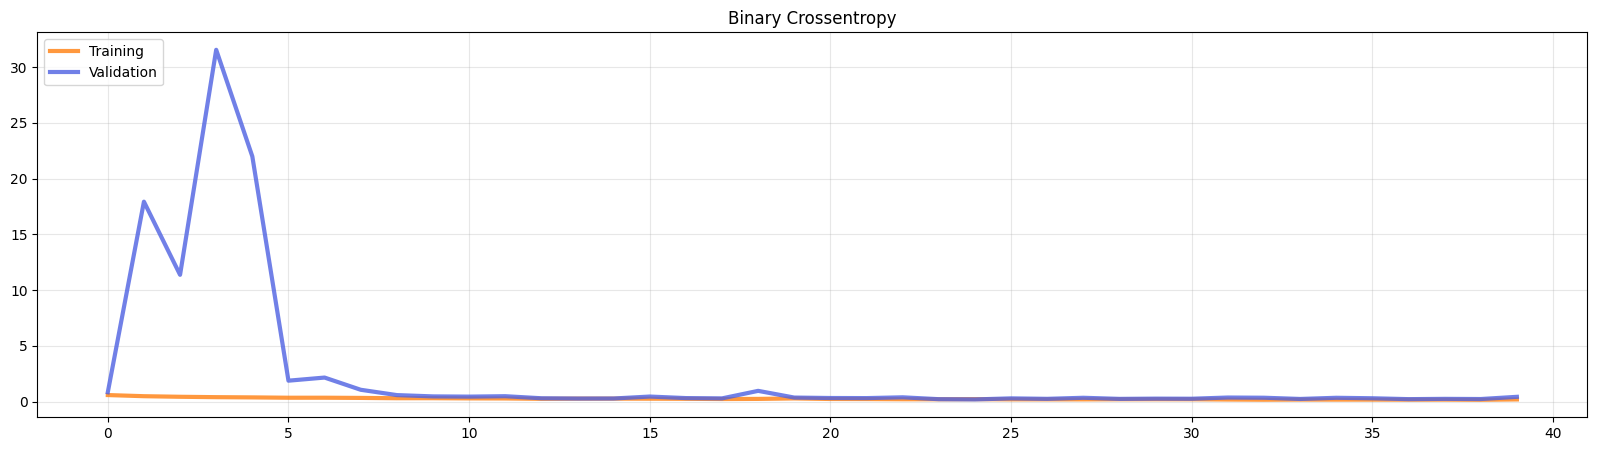

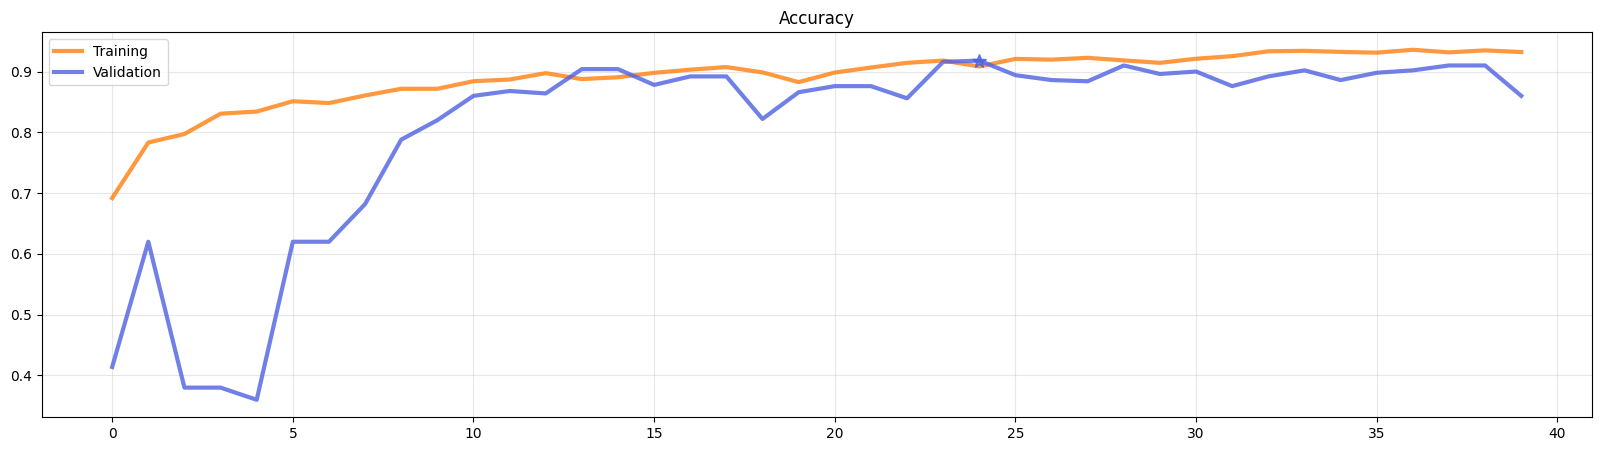

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
# Load model
model = tfk.models.load_model('Model_Transfer_Resnet')

In [ ]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (500, 1)


Accuracy: 0.904
Precision: 0.8901
Recall: 0.8526
F1: 0.871


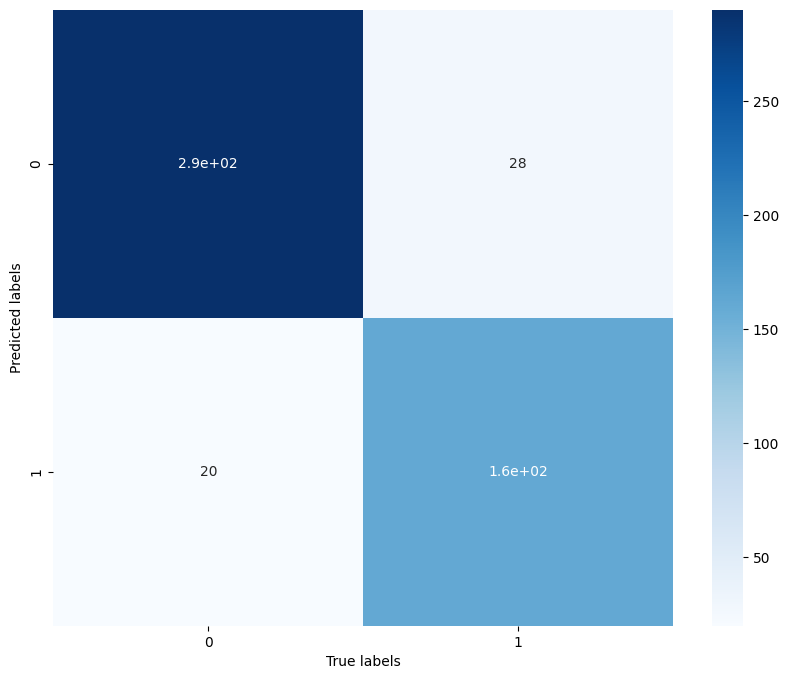

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions.round())

# Compute classification metrics
accuracy = accuracy_score(y_test, predictions.round())
precision = precision_score(y_test, predictions.round())
recall = recall_score(y_test, predictions.round())
f1 = f1_score(y_test, predictions.round())

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()